# 03)Amazon Beauty Product Recommender System  TF-IDF + Cosine Similarity 

In this code notebook, we will perform NLP preprocessing steps on our dataset post EDA. The preprocessing steps includes cleaning our text with the following techniques:
- Converting all text to lowercase
- Remove punctuation
- Remove stopwords
As the text we are performing preprocessing on includes **product model number** and quantity **number ie.300ml**, we will leave the numerical values in the corpus

After which we can build our recommendation system with the following techniques
- TF-IDF
- Cosine Similarity

### What is TF-IDF?

Machine learning cannot be used on raw text directly. We can overcome this problem by converting the text into vectors of numbers.

One of the more popular methods is Bag-Of-Words model.  It is a simple feature extraction technique which describes the occurence of each word within the corpus(document).

Among the Bag-Of-Words model, there are Count Vectorizer and TF-IDF, in this code notebook we will explore the use of TF-IDF.

In Count Vectorizer, it counts the frequency of the word appearing in a document and it might not provide a lot of value for the purpose we are serving in this project.

This is where **TF-IDF** comes into picture, this method penalize words that are frequent across all the documents. TF-IDF, short for term frequency-inverse document frequency is a statistical measure for evaluating the importance of a word to a document.

### Cosine Similarity

Performing TF-IDF is meaningless on it's own in a recommendation system. We require a unit of measure to compare user input with the TF-IDF vectors.

Euclidian similarity cannot work well for the high-dimensional word vectors. This is because Euclidian similarity will increase as the number of dimensions increases, even if the word embedding stands for different meanings.

Cosine similarity is then used instead to measure the similarity between two vectors. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity captures the angle of the word vectors and not the magnitude.

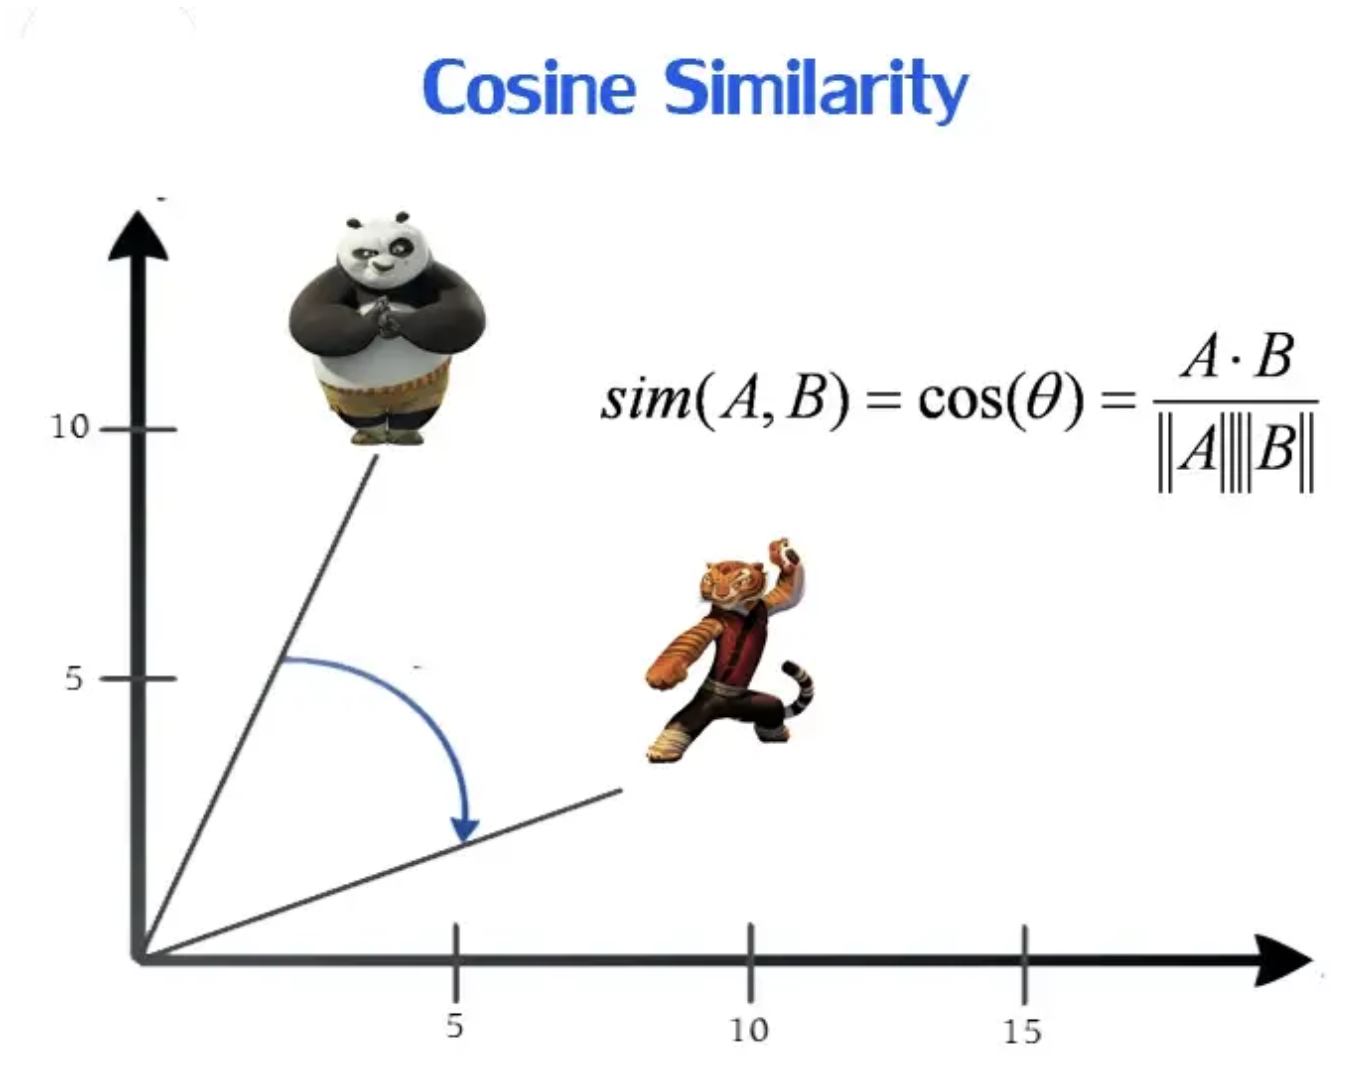


This is an example of Cosine similarity comparing 2 points laying on a 2 dimensional plane.

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

import pickle
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer # RegexpTokenizer uses regex for tokenization
from nltk.stem import WordNetLemmatizer # for lemmatization
from nltk.stem.porter import PorterStemmer # for stemming
from nltk.corpus import stopwords # for stopwords removal
import re
import nltk
from nltk.probability import FreqDist


In [2]:
df = pd.read_pickle("dataset/product_score.pkl")

In [3]:
print(df.shape)
df.head(3)

(314799, 9)


,product_description,product,brand,price,imageURLHighRes,reviewer_score,reviewerID,review,average_reviewer_score
productID,,,,,,,,,
6546546450,[Loud 'N Clear Personal Sound Amplifier allows...,Loud 'N Clear&trade; Personal Sound Amplifier,idea village,,[],4.0,A3349A7IGM954K,"Better amplification, better battery life than...",2.5
6546546450,[Loud 'N Clear Personal Sound Amplifier allows...,Loud 'N Clear&trade; Personal Sound Amplifier,idea village,,[],1.0,A1OMHUU58XHQNG,This item is junk. I bought this for my uncle ...,2.5
7178680776,[No7 Lift & Luminate Triple Action Serum 50ml ...,No7 Lift &amp; Luminate Triple Action Serum 50...,,$44.99,[],3.0,A3Q0QXUKRGACMU,I've been using it for just about 3 weeks. I t...,3.0


We will now drop duplicate rows from the "productID" column

In [4]:
df = df[~df.index.duplicated(keep='first')]

Because TF-IDF is considered bag of words, the order of the words do not matter in this scenario. We will attempt to combine the text under the "product_description" column with the "product" column and perform preprocessing before performing TF-IDF on the text.

In [5]:
#Explore the text within the "product_description" and "product title" columns
def sentence(data,index):
    print("Product Description\n")
    print(df["product_description"][index])
    print("\nProduct title\n")
    print(df["product"][index])

In [6]:
sentence(df,0)

Product Description

["Loud 'N Clear Personal Sound Amplifier allows you to turn up the volume on what people around you are saying, listen at the level you want without disturbing others, hear a pin drop from across the room."]

Product title

Loud 'N Clear&trade; Personal Sound Amplifier


In [7]:
sentence(df,32)

Product Description

["With a pivoting head that oscillates from side to side and large foil holes to capture more hairs, this shaver delivers a smooth shave. When you're done, the shaver stores in a stand that cleans, lubricates, and charges it. The stand has an interactive LCD panel to provide data on charge status and maintenance needs. Operating with or without a cord, the razor has a pop-up trimmer and works worldwide on 110- to 240-volt systems. It recharges in one hour for 50 minutes of shaving time or charges in three minutes for a quick shave. Razor, cord, and cleaning brush fit into a leather traveling case. The Clean & Charge stand offers three options: clean, charge, or both. Cleaning fluid is drawn from a cartridge (included, along with one refill) that lasts for about 30 cleaning cycles and inserts easily into the stand. The shaver carries a two-year warranty against defects (foil and cutter block excluded)", "With a pivoting head that oscillates from side to side and lar

**Taking random examples from 2 rows from the dataset, it is observed that the length of the product description varies from product to product.**

Since we will be implementing **TF-IDF (Bag-Of-Words)**, we will combine the text within both columns to form a corpus

In [8]:
df["product_description"][0]

["Loud 'N Clear Personal Sound Amplifier allows you to turn up the volume on what people around you are saying, listen at the level you want without disturbing others, hear a pin drop from across the room."]

In [9]:
#Example of new clumn on index 0
" ".join(df["product_description"][0]) + " " + df["product"][0]

"Loud 'N Clear Personal Sound Amplifier allows you to turn up the volume on what people around you are saying, listen at the level you want without disturbing others, hear a pin drop from across the room. Loud 'N Clear&trade; Personal Sound Amplifier"

In [10]:
df["combined_text"] = [" ".join(df["product_description"][i]) + " " + df["product"][i] for i in range(len(df))]

In [11]:
df["combined_text"][0]

"Loud 'N Clear Personal Sound Amplifier allows you to turn up the volume on what people around you are saying, listen at the level you want without disturbing others, hear a pin drop from across the room. Loud 'N Clear&trade; Personal Sound Amplifier"

### Preprocessing text data

In [12]:
#Write a function to preprocess our text data
#In our preprocessing stage, we will leave the numbers in the text as they might represent crucial information like model number of the products

#Make text to lower case
def make_lower_case(text):
    return text.lower()

#Remove punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[\w\s]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

#Remove stopwords
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

In [13]:
df['cleaned'] = df['combined_text'].apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(func = remove_punctuation)
df['cleaned'] = df.cleaned.apply(func = remove_stop_words)

In [14]:
#Create new columns for lemmatization

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

df['lemmatized_words'] = df['cleaned'].apply(lambda x: tokenizer.tokenize(x)).apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['lemmatized_text'] = df['lemmatized_words'].apply(lambda x: " ".join(x))

In [15]:
df.head()

,product_description,product,brand,price,imageURLHighRes,reviewer_score,reviewerID,review,average_reviewer_score,combined_text,cleaned,lemmatized_words,lemmatized_text
productID,,,,,,,,,,,,,
6546546450,[Loud 'N Clear Personal Sound Amplifier allows...,Loud 'N Clear&trade; Personal Sound Amplifier,idea village,,[],4.0,A3349A7IGM954K,"Better amplification, better battery life than...",2.5,Loud 'N Clear Personal Sound Amplifier allows ...,loud n clear personal sound amplifier allows t...,"[loud, n, clear, personal, sound, amplifier, a...",loud n clear personal sound amplifier allows t...
7178680776,[No7 Lift & Luminate Triple Action Serum 50ml ...,No7 Lift &amp; Luminate Triple Action Serum 50...,,$44.99,[],3.0,A3Q0QXUKRGACMU,I've been using it for just about 3 weeks. I t...,3.0,No7 Lift & Luminate Triple Action Serum 50ml b...,no7 lift luminate triple action serum 50ml boo...,"[no7, lift, luminate, triple, action, serum, 5...",no7 lift luminate triple action serum 50ml boo...
7250468162,[No7 Stay Perfect Foundation now stays perfect...,No7 Stay Perfect Foundation Cool Vanilla by No7,No7,$28.76,[],5.0,A3MQI5EJSEDO1K,It's difficult to find sometimes so I'm glad t...,5.0,No7 Stay Perfect Foundation now stays perfect ...,no7 stay perfect foundation stays perfect long...,"[no7, stay, perfect, foundation, stay, perfect...",no7 stay perfect foundation stay perfect longe...
7367905066,[],Wella Koleston Perfect Hair Colour 44/44 Mediu...,,,[https://images-na.ssl-images-amazon.com/image...,5.0,A29TKERPFM55B6,Great color. Covers my gray better than any ha...,5.0,Wella Koleston Perfect Hair Colour 44/44 Medi...,wella koleston perfect hair colour 44 44 mediu...,"[wella, koleston, perfect, hair, colour, 44, 4...",wella koleston perfect hair colour 44 44 mediu...
7414204790,[Lacto Calamine Skin Balance Daily Nourishing ...,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,$12.15,[https://images-na.ssl-images-amazon.com/image...,5.0,A5TA1NJOC0PJ5,Excellent very good,4.4,Lacto Calamine Skin Balance Daily Nourishing L...,lacto calamine skin balance daily nourishing l...,"[lacto, calamine, skin, balance, daily, nouris...",lacto calamine skin balance daily nourishing l...


### Building our TF-IDF + Cosine Similarity recommendation system

In [16]:
tfidf = TfidfVectorizer(stop_words='english',ngram_range = (1,3))#Vectorize based on unigram, bigram and trigram
tfidf_matrix = tfidf.fit_transform(df['lemmatized_text'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [17]:
#Computing cosine similarity with product corpus

def extract_best_indices(m, topk, mask=None):
    
    # return the sum on all tokens of cosinus for each sentence
    if len(m.shape) > 1:
        cos_sim = np.mean(m, axis=0) 
    else: 
        cos_sim = m
    index = np.argsort(cos_sim)[::-1] # from highest idx to smallest score 
    if mask is not None:
        assert mask.shape == m.shape
        mask = mask[index]
    else:
        mask = np.ones(len(cos_sim))
    mask = np.logical_or(cos_sim[index] != 0, mask) #eliminate 0 cosine distance
    best_index = index[mask][:topk]  
    return best_index

In [18]:
#Writing a function to compare input sentence to TF-IDF matrix
def get_recommendations_tfidf(sentence, tfidf_matrix):
    
    # Embed the query sentence
    tokens_query = [str(tok) for tok in word_tokenize(sentence)]
    embed_query = tfidf.transform(tokens_query)
    # Create list with similarity between query and dataset
    mat = cosine_similarity(embed_query, tfidf_matrix)
    # Best cosine distance for each token independantly
    best_index = extract_best_indices(mat, topk=5)
    return best_index

#### Test user input: "bottle of perfume"

In [30]:
#Test our TF-IDF model and see the top 5 products based on cosine similarity
test = "bottle of perume"
best_index = get_recommendations_tfidf(test,tfidf_matrix)
display(df[['product', 'brand', 'price','review', 'average_reviewer_score', 'imageURLHighRes']].iloc[best_index])

,product,brand,price,review,average_reviewer_score,imageURLHighRes
productID,,,,,,
B01AVEYW2G,2 bottles Sheep Placenta Complex 100 Capsules ...,nu-health,$18.78,My mom loves it.,5.0,[https://images-na.ssl-images-amazon.com/image...
B01AYIWZAU,"Rugby UNICOMPLEX-M, 90 Tablets Per Bottle (5 B...",,$26.81,These are great vitamins. Will take them fore...,5.0,[]
B00ZVF8BHS,Essential Oil Bottles Set 16 Piece Amber Glass...,,,This is PERFECT for beginning EO experimenters...,4.0,[]
B0010Q7J2U,Roux Color Applicator Bottle 9 oz,,,"Love these bottles. Have used them as ""downstr...",4.0,[]
B005CKN6L8,Twist Top Plastic Bottle,,$1.64,Company is good but this product is not. The ...,3.0,[]


In [26]:
#Pickle df
df.to_pickle('dataset/df_for_model.pkl')